# Data Description

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allow viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. There is also a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data which has been anonymised.

# Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. 

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

# Data Science Problem Statement(s)

Through this dataset, I will use various machine learning methods for the following problems -  

1) Segmentation - How can customers be clustered based on their purchase habits?   
2) Customer Lifetime Value - How much will a customer bring in future revenue?  
3) Churn - Which customers are likely to remain or not remain with Olist?  
4) Recommendations - How can we increase user basket size by engaging users more with a recommendation system?  
5) Customer reviews - Can we predict customer review scores based on the various features?



The data is divided into multiple datasets for better organization. As such I will be working with different sub sets across the various project steps - depending on the objective. Please refer to the following data schema for clarity:
<img src="https://i.imgur.com/HRhd2Y0.png" />

# Why CLTV:
CLTV analysis and customer-centric approach to marketing has lead to a success story in quantitative analytics with the increasing availability of transaction data. A number of studies have developed scoring mechanisms (e.g. regression models to predict a customer’s future behavior). The measures of a customer’s past behavior are key predictors of their future behavior in all the empirical analysis. It is common practice to summarize a customer’s past behavior by investigating the “RFM” characteristics: recency (time of most recent purchase), frequency (number of past purchases), and monetary value (average purchase amount per transaction). However, empirical studies reveal the limitations with these models when seeking to develop CLTV estimates.

# The logic behind customer segmentation
Not all customers are equally important to a firm. Maintaining long-term relation with all of them (especially the loss makers) is not optimal because eventually marketing is all about attracting and retaining profitable customers (Kotler and Armstrong 1996). Hence the objective of CLTV is firstly on general topics of firm’s profitability and secondly as an input in customer acquisition decision and customer acquisition/retention trade-offs (Berger and Nasr 1998).

# Business objectives:


To build a probabilistic model for predicting CLTV on an individual level. Using the results of this exercise, managers should be able to  

1) Distinguish active customers from inactive customers.  
2) Generate transaction forecasts for individual customers.  
3) Predict the purchase volume of the entire customer base.  
4) Predict customer churn risk.    

## Contents:
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [BG/NBD Model](#BG/NBD-Model)
- [Predicting customer lifetime value](#Model-Evaluation)
- [Churn Risk](#Churn-Risk)
- [Next Steps](#Next-Steps)

# Data Import and Cleaning

In [1]:
#importing all the required libraries
%pylab inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go

np.random.seed(42)
import random
random.seed(42)
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta, date
import gc
import itertools

from pylab import figure, text, scatter, show

import lifetimes

from lifetimes.utils import calibration_and_holdout_data
from lifetimes import BetaGeoFitter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.plotting import *
from lifetimes.utils import *
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff


Populating the interactive namespace from numpy and matplotlib


In [2]:
df1 = pd.read_csv('../datasets/olist/olist_orders_dataset.csv')
df2 = pd.read_csv('../datasets/olist/olist_customers_dataset.csv')
df3 = pd.read_csv('../datasets/olist/olist_order_payments_dataset.csv')
df4 = pd.read_csv('../datasets/olist/olist_order_items_dataset.csv')

In [3]:
df2.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
dtype: int64

Here we can see that the majority of customers made only a single purchase

In [4]:
orders = pd.merge(df1,df2[['customer_id','customer_unique_id']],on='customer_id')
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id'],
      dtype='object')

In [5]:
df4.drop_duplicates('order_id',keep='first',inplace=True)

In [6]:
transaction_data = pd.merge(orders,df4,'inner','order_id')

In [7]:
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]
# convert timestamp to date
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


# Nomenclature used:
1) Frequency (F) is the number of repeat purchases the customer has made.  
2) T represents the age of the customer which is equal to the duration between a customer’s first purchase and the end of the period under study.   
3) Recency (R) is the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase.   

Lastly, I will look at customer average purchase value as Monetary value.   

Together, these components are called the RFM Matrix.

The Lifetimes package has a function for converting transaction data into an RFM DataFrame - this will be used as below

In [8]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


It seems a lot of customers have zero frequency, recency, and monetary values. This is because Lifetimes only considers customers who have made repeat purchases into account. 

# BG/NBD Model
## Using only recency and frequency to predict customer lifetime value
Lifetimes links the RFM (recency, frequency, monetary value) paradigm with customer lifetime value (CLTV). The stochastic model presented here, featuring BG/NBD framework to capture the flow of transactions over time. BG/NBD portrays the story being about how/when customers become inactive.

The BG/NBD requires only two pieces of information about each customer’s past purchasing history: “recency” (when the last transaction occurred) and “frequency” (how many transactions was made in a specified time period).

In [9]:
bgf = BetaGeoFitter(penalizer_coef=0.00)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

# Visualizing the RFM DataFrame
Assumptions of the BG/NBD model:  
1) A customer’s relationship has two phases: “alive” for an unobserved period of time, then “dead”  
2) While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate lambda  
3) Heterogeneity in lambda follows a gamma distribution  
4) After any transaction, a customer dies with probability p; the probability that a customer dies after a number of transactions follows a geometric distribution  


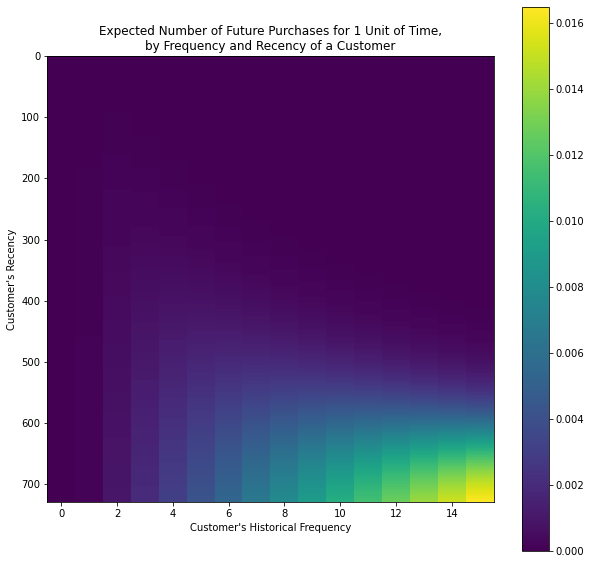

In [10]:
plt.figure(figsize=(10, 10))
plot_frequency_recency_matrix(bgf)

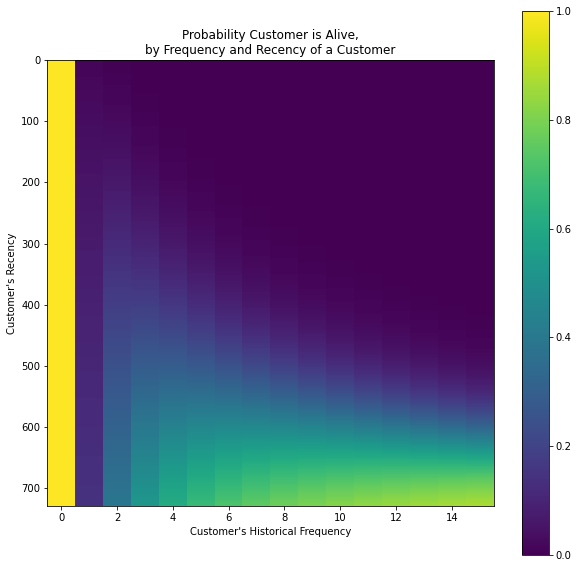

In [11]:
plt.figure(figsize=(10, 10))
plot_probability_alive_matrix(bgf)


# Model Evaluation

## Modeling Future Purchases(Life Time Value) 

1) Calibration period histogram: does the model fit the training data?  
2) Cumulative transaction plot: does the model predict cumulative sales well?  
3) Incremental transaction plot: does the model capture the overall trend in transactions?  
4) Conditional expectations plot: can the model predict the number of purchases a customer will make based on the training data?

# 1) Does the model fit the training data?

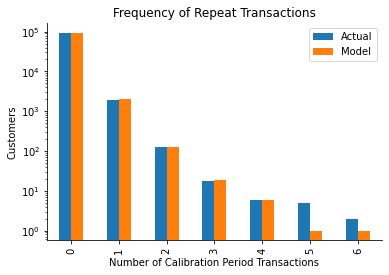

In [12]:
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

The actual and simulated data seem to match well, but it starts to falter after 4 repeat transactions. 

# 2) Can we predict future sales?

In [13]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )

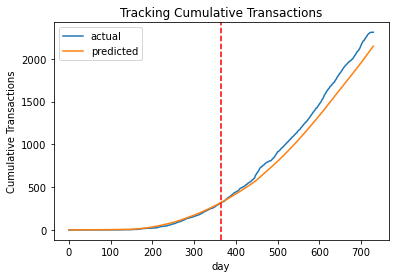

In [14]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365)

The red line represents the boundary between the calibration period on the left and the holdout period on the right. As you can see, the BG/NBD model is good at predicting cumulative transactions.

# 3) Predicting daily transactions over time

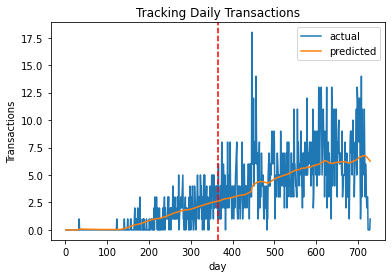

In [15]:
plot_incremental_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);

The model appears to capture daily transcations fairly well.

# 4) Can we predict number of purchases made?

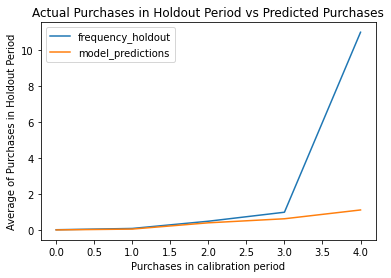

In [16]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

The model performs well up to three calibration period purchases, but diverges from the holdout data because of the distribution of the data.  Less than 1% of customers have made four or more purchases, so there’s not much data for the BG/NBD model to learn about customers who have made many repeat transactions.

# Churn Risk

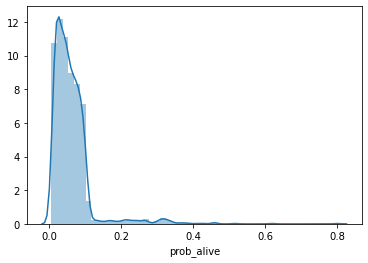

In [17]:
#limiting to customers who have made at least one repeat transaction
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive'])

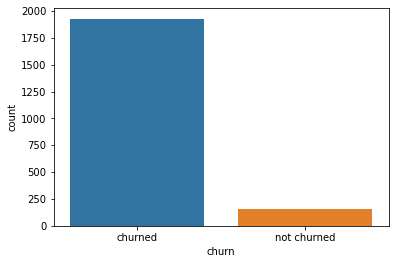

In [18]:
#assuming customers with under 10% chance of being predicted as 'alive' to be churned
df['churn'] = ['churned' if p < 0.1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn'])

More than 90% of customers have churned. 

This implies that there is significant opportunity for improvement regarding retention. We can assume that the customers who have churned are already lost.

It may be prudent to find the customers who are at high risk for churn, but haven’t churned yet. This is so that we can try to actively identify and retain these customers.

Text(0.5, 1.0, 'Probability alive, not churned')

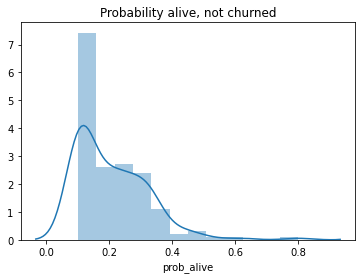

In [19]:
sns.distplot(df[df['churn']=='not churned']['prob_alive']).set_title('Probability alive, not churned')

Lets assume that customers between 10-30% alive probability are high risk. 

In [20]:
df['churn'][(df['prob_alive']>=0.1) & (df['prob_alive']<0.3)] = "high risk"
df['churn'].value_counts()

churned        1928
high risk       120
not churned      37
Name: churn, dtype: int64

With these insights, we can discuss best practices with the marketing team on potential strategies to retain the 120 high risk customers.

# Next Steps

It is evident from this dataset that repeat customers (frequency) is rather low with 95% of customers only buying once in the data period.   

In the next notebook, I will aim to predict customer satisfaction to see what are the main drivers - and if any more exploration is needed.  